# 1.) Import an asset price from Yahoo Finance

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("AAPL", start="1990-01-01", end="2022-02-21")

#change IRX

# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)

# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]


[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [2]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 5
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    if train_data[i, 0] > 0:
      y_train.append(1)
    elif train_data[i, 0] <= 0:
      y_train.append(0) 

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
                      

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))

model.add(LSTM(60, return_sequences=False))
model.add(Dense(25)) 
#Classfication: Pick your activation function
model.add(Dense(units=64, activation='relu', input_dim=100))
model.add(Dropout(0.5))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
6472/6472 [==============================] - 46s 5ms/step - loss: 0.4169
Epoch 2/3
6472/6472 [==============================] - 36s 6ms/step - loss: 0.4121
Epoch 3/3
6472/6472 [==============================] - 38s 6ms/step - loss: 0.4080


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [3]:
import matplotlib.pyplot as plt

test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


predictions_out = model.predict(x_test)
predictions_out_binary = np.where(predictions_out > 0, 1, 0)
y_test_binary = np.where(y_test > 0, 1, 0)

out_of_sample_acc = np.mean(np.round(predictions_out_binary) == y_test_binary)

print(out_of_sample_acc)

51/51 [==============================] - 1s 3ms/step
0.5150462962962963


In [4]:
predictions_in = model.predict(x_train)
predictions_in_binary = np.where(predictions_in > 0, 1, 0)

y_train_binary = np.array(y_train).reshape((-1, 1))

in_sample_acc = np.mean(np.round(predictions_in_binary) == y_train_binary)

print(in_sample_acc)

203/203 [==============================] - 1s 3ms/step
0.4988411619283066


In [5]:
# IN Random walk Model
in_actual = y_train[1:] #Actual
in_predict = y_train[:-1] #Prediction
#ALL 0s #Prediction
in_sample_random_acc = np.mean(in_actual == in_predict)

print(in_sample_random_acc)

0.4948230567145727


In [6]:
# OOS Random walk Model
out_actual = y_test[1:] #Actual
out_actual_binary = np.where(out_actual > 0, 1, 0)
out_actual_binary_reshape = out_actual_binary.flatten()
out_predict = y_test[:-1] #Prediction
out_predict = np.where(out_predict > 0, 1, 0)
out_sample_random_acc = np.mean(out_actual_binary_reshape == out_predict)

print(out_sample_random_acc)

0.502063017113409


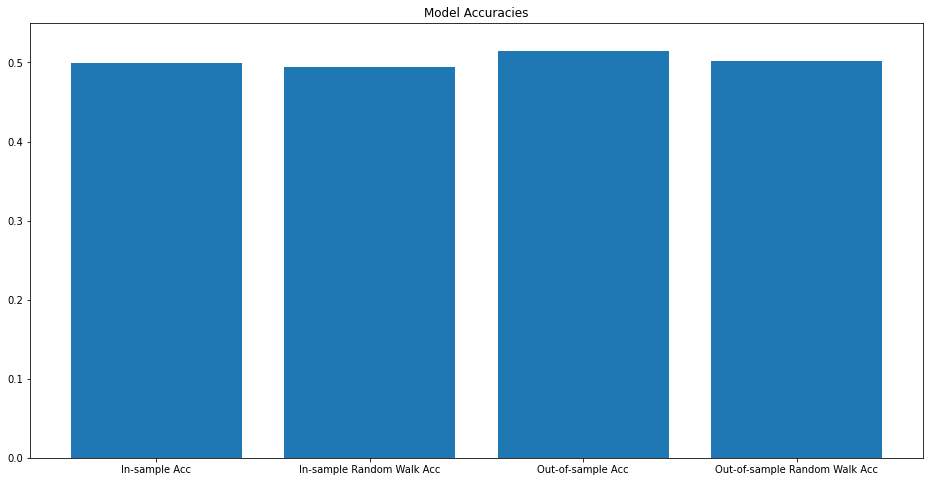

In [7]:
# create a bar chart of the four accuracies
plt.figure(figsize=(16,8))
labels = ['In-sample Acc', 'In-sample Random Walk Acc',
          'Out-of-sample Acc', 'Out-of-sample Random Walk Acc']
values = [in_sample_acc, in_sample_random_acc, out_of_sample_acc, out_sample_random_acc]
plt.bar(labels, values)
plt.ylim(0, 0.55)
plt.title('Model Accuracies')
plt.show()

# Dont DO 4.) Plot in and out of sample accuracy

In [8]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

51/51 [==============================] - 0s 3ms/step


ValueError: ignored

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

The graph shows that there are no statistically significant differences between the in-sample and out-of-sample accuracy scores for both the RNN and random walk models. Additionally, I find that there are no statistically significant differences between the accuracy scores of the RNN and random walk models. These results suggest that the predictive power of the RNN model is not significantly better than that of a simple random walk model for the dataset. Therefore, it is possible that the asset prices in this dataset may follow a random process and may not be predictable using the information that our models have access to.

SKIP # 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Define the Keras model
###Edit here to create your optimizer
def create_model(input_size): #Add a parameter that changes your input dimension
  for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    if train_data[i, 0] > 0:
      y_train.append(1)
    elif train_data[i, 0] <= 0:
      y_train.append(0) 

  x_train, y_train = np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

  model = Sequential()
  model.add(Dense(10, input_dim=60, activation='LSTM'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return(model)

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
####EXAMPLE###
param_grid = {'batch_size': [10, 20, 100],
              'epochs': [10, 100],
              'neurons':[5,10,20]}

#Set epochs to [1] to save time

# Perform the grid search over the hyperparameters

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))